# Stock Correlation Research
This notebook fetches stock data from Polygon API and calculates correlations between stock pairs.

In [1]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from itertools import combinations
import os
from typing import List, Tuple, Dict

In [ ]:
# Configuration
POLYGON_API_KEY = os.getenv('POLYGON_API_KEY', '')
print(POLYGON_API_KEY)

# List of stock symbols to analyze
SYMBOLS = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META',
    'TSLA', 'NVDA', 'JPM', 'V', 'WMT',
    'JNJ', 'PG', 'MA', 'UNH', 'HD',
    'BAC', 'DIS', 'ADBE', 'CRM', 'NFLX'
]

# Date range for data
END_DATE = datetime.now()
START_DATE = END_DATE - timedelta(days=365)  # 1 year of data

# Timespan for aggregation
TIMESPAN = 'day'
MULTIPLIER = 1

abEgGQWtzBpMvz1H4o00DHvEMoG1G_Md


In [10]:
def fetch_stock_data(symbol: str, start_date: datetime, end_date: datetime) -> pd.DataFrame:
    """
    Fetch stock data from Polygon API
    
    Args:
        symbol: Stock ticker symbol
        start_date: Start date for data
        end_date: End date for data
    
    Returns:
        DataFrame with stock price data
    """
    url = f"https://api.polygon.io/v2/aggs/ticker/{symbol}/range/{MULTIPLIER}/{TIMESPAN}/{start_date.strftime('%Y-%m-%d')}/{end_date.strftime('%Y-%m-%d')}"
    
    params = {
        'apiKey': POLYGON_API_KEY,
        'adjusted': 'true',
        'sort': 'asc'
    }
    
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        
        if 'results' not in data or not data['results']:
            print(f"No data returned for {symbol}")
            return pd.DataFrame()
        
        df = pd.DataFrame(data['results'])
        df['date'] = pd.to_datetime(df['t'], unit='ms')
        df = df.set_index('date')
        df = df[['c']].rename(columns={'c': symbol})
        
        return df
    
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        return pd.DataFrame()

In [23]:
import time
def fetch_all_stocks(symbols: List[str]) -> pd.DataFrame:
    """
    Fetch data for all stocks and combine into a single DataFrame
    
    Args:
        symbols: List of stock ticker symbols
    
    Returns:
        DataFrame with all stock prices
    """
    all_data = []
    
    for symbol in symbols:
        print(f"Fetching data for {symbol}...")
        df = fetch_stock_data(symbol, START_DATE, END_DATE)
        if not df.empty:
            all_data.append(df)
        time.sleep(10)
    
    if not all_data:
        return pd.DataFrame()
    
    # Combine all dataframes
    combined_df = pd.concat(all_data, axis=1)
    
    # Forward fill missing values (for holidays/weekends)
    combined_df = combined_df.fillna(method='ffill')
    
    # Drop any remaining NaN values
    combined_df = combined_df.dropna()
    
    return combined_df

In [12]:
def calculate_returns(price_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate daily percentage returns
    
    Args:
        price_df: DataFrame with stock prices
    
    Returns:
        DataFrame with daily returns
    """
    return price_df.pct_change().dropna()

In [13]:
def find_correlations(returns_df: pd.DataFrame) -> List[Tuple[str, str, float]]:
    """
    Calculate correlations between all stock pairs
    
    Args:
        returns_df: DataFrame with stock returns
    
    Returns:
        List of tuples (stock1, stock2, correlation) sorted by correlation
    """
    correlations = []
    symbols = returns_df.columns.tolist()
    
    # Calculate correlation for each pair
    for stock1, stock2 in combinations(symbols, 2):
        corr = returns_df[stock1].corr(returns_df[stock2])
        correlations.append((stock1, stock2, corr))
    
    # Sort by absolute correlation (highest first)
    correlations.sort(key=lambda x: abs(x[2]), reverse=True)
    
    return correlations

In [24]:
# Fetch stock data
print("Fetching stock data from Polygon API...\n")
price_data = fetch_all_stocks(SYMBOLS)

if price_data.empty:
    print("No data retrieved. Please check your API key and symbols.")
else:
    print(f"\nSuccessfully fetched data for {len(price_data.columns)} stocks")
    print(f"Date range: {price_data.index.min()} to {price_data.index.max()}")
    print(f"Total data points: {len(price_data)} days")

Fetching stock data from Polygon API...

Fetching data for AAPL...
Fetching data for MSFT...
Fetching data for GOOGL...
Fetching data for AMZN...
Fetching data for META...
Fetching data for TSLA...
Error fetching data for TSLA: 429 Client Error: Too Many Requests for url: https://api.polygon.io/v2/aggs/ticker/TSLA/range/1/day/2024-10-21/2025-10-21?apiKey=abEgGQWtzBpMvz1H4o00DHvEMoG1G_Md&adjusted=true&sort=asc
Fetching data for NVDA...
Fetching data for JPM...
Fetching data for V...
Fetching data for WMT...
Fetching data for JNJ...
Fetching data for PG...
Error fetching data for PG: 429 Client Error: Too Many Requests for url: https://api.polygon.io/v2/aggs/ticker/PG/range/1/day/2024-10-21/2025-10-21?apiKey=abEgGQWtzBpMvz1H4o00DHvEMoG1G_Md&adjusted=true&sort=asc
Fetching data for MA...
Fetching data for UNH...
Fetching data for HD...
Fetching data for BAC...
Fetching data for DIS...
Fetching data for ADBE...
Error fetching data for ADBE: 429 Client Error: Too Many Requests for url: http

/var/folders/b_/rf0bpmls55x3h72ntzc7330m0000gn/T/ipykernel_60051/3383791223.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df = combined_df.fillna(method='ffill')


In [27]:
# Calculate returns
returns_data = calculate_returns(price_data)
print(f"Calculated daily returns for {len(returns_data)} trading days")

Calculated daily returns for 249 trading days


In [28]:
# Calculate correlations
print("\nCalculating correlations between all stock pairs...\n")
correlations = find_correlations(returns_data)

print(f"Total pairs analyzed: {len(correlations)}\n")


Calculating correlations between all stock pairs...

Total pairs analyzed: 136



In [29]:
# Display top 20 highest correlations
print("\n" + "="*60)
print("TOP 20 HIGHEST CORRELATIONS (by absolute value)")
print("="*60)
print(f"{'Stock 1':<10} {'Stock 2':<10} {'Correlation':>15}")
print("-"*60)

for stock1, stock2, corr in correlations[:20]:
    print(f"{stock1:<10} {stock2:<10} {corr:>15.4f}")


TOP 20 HIGHEST CORRELATIONS (by absolute value)
Stock 1    Stock 2        Correlation
------------------------------------------------------------
V          MA                  0.9009
JPM        BAC                 0.8185
AMZN       META                0.7386
MSFT       META                0.6718
MSFT       AMZN                0.6709
JPM        V                   0.6322
MSFT       NVDA                0.6298
BAC        DIS                 0.6274
JPM        MA                  0.6109
GOOGL      AMZN                0.5981
MA         BAC                 0.5966
JPM        DIS                 0.5940
AMZN       NVDA                0.5903
AAPL       AMZN                0.5851
V          BAC                 0.5836
META       NVDA                0.5752
MA         DIS                 0.5627
AMZN       CRM                 0.5434
AMZN       JPM                 0.5434
V          DIS                 0.5429


In [30]:
# Create a DataFrame with all correlations for further analysis
correlation_df = pd.DataFrame(correlations, columns=['Stock 1', 'Stock 2', 'Correlation'])
correlation_df['Abs_Correlation'] = correlation_df['Correlation'].abs()

# Display summary statistics
print("\n" + "="*60)
print("CORRELATION SUMMARY STATISTICS")
print("="*60)
print(f"Mean correlation: {correlation_df['Correlation'].mean():.4f}")
print(f"Median correlation: {correlation_df['Correlation'].median():.4f}")
print(f"Max correlation: {correlation_df['Correlation'].max():.4f}")
print(f"Min correlation: {correlation_df['Correlation'].min():.4f}")
print(f"Std deviation: {correlation_df['Correlation'].std():.4f}")

correlation_df.head(10)


CORRELATION SUMMARY STATISTICS
Mean correlation: 0.3539
Median correlation: 0.4059
Max correlation: 0.9009
Min correlation: -0.2585
Std deviation: 0.2122


,Stock 1,Stock 2,Correlation,Abs_Correlation
0,V,MA,0.900858,0.900858
1,JPM,BAC,0.818509,0.818509
2,AMZN,META,0.738578,0.738578
3,MSFT,META,0.671787,0.671787
4,MSFT,AMZN,0.670944,0.670944
5,JPM,V,0.632158,0.632158
6,MSFT,NVDA,0.629815,0.629815
7,BAC,DIS,0.627352,0.627352
8,JPM,MA,0.610878,0.610878
9,GOOGL,AMZN,0.598126,0.598126


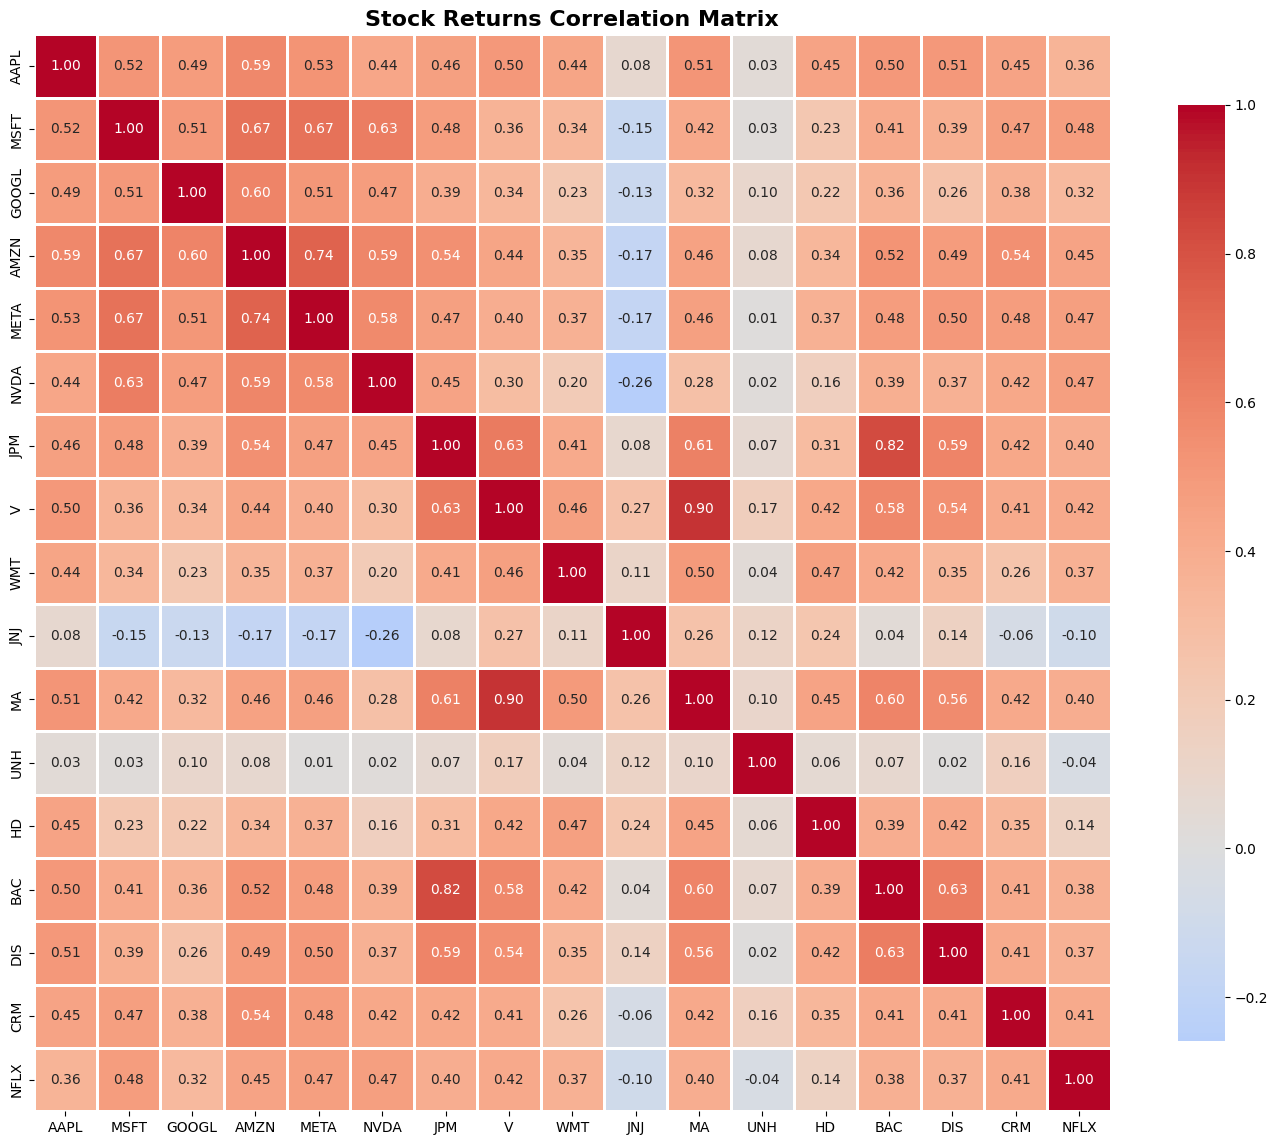

In [31]:
# Optional: Visualize correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 12))
correlation_matrix = returns_data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Stock Returns Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [32]:
# Display bottom 10 (most negative correlations)
print("\n" + "="*60)
print("TOP 10 MOST NEGATIVE CORRELATIONS")
print("="*60)
print(f"{'Stock 1':<10} {'Stock 2':<10} {'Correlation':>15}")
print("-"*60)

sorted_by_value = sorted(correlations, key=lambda x: x[2])
for stock1, stock2, corr in sorted_by_value[:10]:
    print(f"{stock1:<10} {stock2:<10} {corr:>15.4f}")


TOP 10 MOST NEGATIVE CORRELATIONS
Stock 1    Stock 2        Correlation
------------------------------------------------------------
NVDA       JNJ                -0.2585
AMZN       JNJ                -0.1715
META       JNJ                -0.1714
MSFT       JNJ                -0.1496
GOOGL      JNJ                -0.1331
JNJ        NFLX               -0.0996
JNJ        CRM                -0.0561
UNH        NFLX               -0.0397
META       UNH                 0.0113
UNH        DIS                 0.0151


In [33]:
# Save results to CSV
output_file = 'stock_correlations.csv'
correlation_df.to_csv(output_file, index=False)
print(f"\nResults saved to {output_file}")


Results saved to stock_correlations.csv
